In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from codecarbon import EmissionsTracker

In [ ]:
import pandas as pd

features_v1 = pd.read_csv('/Users/christinadong/Documents/MLops/ml-feature-store-pipeline/data/feature_v1.csv')
features_v2 = pd.read_csv('/Users/christinadong/Documents/MLops/ml-feature-store-pipeline/data/feature_v2.csv')
# Drop non-numeric ID and timestamp columns
features_v1 = features_v1.drop(columns=["event_timestamp", "athlete_id"], errors='ignore')
features_v2 = features_v2.drop(columns=["event_timestamp", "athlete_id"], errors='ignore')

print("--- V1 Features Ready for Model ---")
print(features_v1.head())
print("\n--- New and Improved V2 Features Ready for Model ---")
print(features_v2.head())

--- V1 Features Ready for Model ---
    age  height  weight  gender  deadlift  candj  snatch  backsq
0  30.0    71.0   200.0       1     385.0  235.0   175.0   315.0
1  28.0    70.0   176.0       1     335.0  187.0   134.0   254.0
2  35.0    68.0   225.0       1     440.0  285.0   205.0   405.0
3  36.0    71.0   199.0       1     485.0  267.0   212.0   390.0
4  36.0    64.0   155.0       1     415.0  245.0   180.0   385.0

--- New and Improved V2 Features Ready for Model ---
    age  height  weight  gender  deadlift  candj  snatch  backsq        BMI  \
0  30.0    71.0   200.0       1     385.0  235.0   175.0   315.0  61.495858   
1  28.0    70.0   176.0       1     335.0  187.0   134.0   254.0  55.673581   
2  35.0    68.0   225.0       1     440.0  285.0   205.0   405.0  75.421864   
3  36.0    71.0   199.0       1     485.0  267.0   212.0   390.0  61.188379   
4  36.0    64.0   155.0       1     415.0  245.0   180.0   385.0  58.654902   

   age_group  
0          2  
1          2  


[codecarbon INFO @ 11:28:41] Energy consumed for RAM : 0.000375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:28:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:28:41] Energy consumed for All CPU : 0.002657 kWh
[codecarbon INFO @ 11:28:41] 0.003032 kWh of electricity used since the beginning.


In [13]:
features_v1['total_lift'] = features_v1[['deadlift', 'candj', 'snatch', 'backsq']].sum(axis=1)
target_v1 = features_v1['total_lift']

features_v2['total_lift'] = features_v2[['deadlift', 'candj', 'snatch', 'backsq']].sum(axis=1)
target_v2 = features_v2['total_lift']

In [ ]:
import os
os.makedirs("emissions_log", exist_ok=True)

def train_and_evaluate_regressor(features, target, hyperparameters):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    model = RandomForestRegressor(**hyperparameters, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return {'rmse': rmse, 'r2_score': r2}, model

experiment_datasets = {
    'v1': (features_v1, target_v1),
    'v2': (features_v2, target_v2)
}
hyperparameter_sets = {
    'hp1': {'n_estimators': 100, 'max_depth': 10},
    'hp2': {'n_estimators': 200, 'max_depth': 20}
}

experiment_log = []
trained_models = {}

for version_name, (features, target) in experiment_datasets.items():
    for hp_name, params in hyperparameter_sets.items():
        run_name = f"{version_name}_{hp_name}"
        print(f"\n Running experiment: {run_name}...")

        tracker = EmissionsTracker(project_name="athlete_model_training", output_dir="emissions_log", output_file=f"{run_name}_emissions.csv")
        tracker.start()

        metrics, model = train_and_evaluate_regressor(features, target, params)

        emissions = tracker.stop()

        log_entry = {
            'run_name': run_name,
            'feature_version': version_name,
            'hyperparameters': hp_name,
            'rmse': metrics['rmse'],
            'r2_score': metrics['r2_score'],
            'emissions_kg': emissions
        }
        experiment_log.append(log_entry)
        trained_models[run_name] = model


[codecarbon WARNING @ 11:29:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 11:29:17] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 11:29:17] [setup] RAM Tracking...
[codecarbon INFO @ 11:29:18] [setup] CPU Tracking...
[codecarbon WARNING @ 11:29:18] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.



 Running experiment: v1_hp1...


[codecarbon WARNING @ 11:29:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:29:18] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 11:29:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:29:18] [setup] GPU Tracking...
[codecarbon INFO @ 11:29:18] No GPU found.
[codecarbon INFO @ 11:29:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:29:18] >>> Tracker's metadata:
[codecarbon INFO @ 11:29:18]   Platform system: macOS-15.5-arm64-arm-64bit
[codecarbon INFO @ 11:29:18]   Python version: 3.10.18
[codecarbon INFO @ 11:29:18]   CodeCarbon version: 3.0.4
[codecarbon INFO @ 11:29:18]


 Running experiment: v1_hp2...


[codecarbon WARNING @ 11:29:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:29:24] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 11:29:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:29:24] [setup] GPU Tracking...
[codecarbon INFO @ 11:29:24] No GPU found.
[codecarbon INFO @ 11:29:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:29:24] >>> Tracker's metadata:
[codecarbon INFO @ 11:29:24]   Platform system: macOS-15.5-arm64-arm-64bit
[codecarbon INFO @ 11:29:24]   Python version: 3.10.18
[codecarbon INFO @ 11:29:24]   CodeCarbon version: 3.0.4
[codecarbon INFO @ 11:29:24]


 Running experiment: v2_hp1...


[codecarbon WARNING @ 11:29:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:29:31] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 11:29:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:29:31] [setup] GPU Tracking...
[codecarbon INFO @ 11:29:31] No GPU found.
[codecarbon INFO @ 11:29:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:29:31] >>> Tracker's metadata:
[codecarbon INFO @ 11:29:31]   Platform system: macOS-15.5-arm64-arm-64bit
[codecarbon INFO @ 11:29:31]   Python version: 3.10.18
[codecarbon INFO @ 11:29:31]   CodeCarbon version: 3.0.4
[codecarbon INFO @ 11:29:31]


 Running experiment: v2_hp2...


[codecarbon WARNING @ 11:29:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 11:29:34] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 11:29:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:29:34] [setup] GPU Tracking...
[codecarbon INFO @ 11:29:34] No GPU found.
[codecarbon INFO @ 11:29:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 11:29:34] >>> Tracker's metadata:
[codecarbon INFO @ 11:29:34]   Platform system: macOS-15.5-arm64-arm-64bit
[codecarbon INFO @ 11:29:34]   Python version: 3.10.18
[codecarbon INFO @ 11:29:34]   CodeCarbon version: 3.0.4
[codecarbon INFO @ 11:29:34]

[codecarbon INFO @ 11:29:41] Energy consumed for RAM : 0.000475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:29:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:41] Energy consumed for All CPU : 0.003365 kWh
[codecarbon INFO @ 11:29:41] 0.003840 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:29:56] Energy consumed for RAM : 0.000500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:29:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:29:56] Energy consumed for All CPU : 0.003542 kWh
[codecarbon INFO @ 11:29:56] 0.004042 kWh of electricity used since the beginning.


In [ ]:
results_df = pd.DataFrame(experiment_log)
print("\n--- Quantitative Experiment Results Table ---")
print(results_df)


--- Quantitative Experiment Results Table ---
  run_name feature_version hyperparameters      rmse  r2_score  emissions_kg
0   v1_hp1              v1             hp1  1.994346  0.999948  1.266097e-05
1   v1_hp2              v1             hp2  1.961682  0.999950  1.638641e-07
2   v2_hp1              v2             hp1  2.004271  0.999947  1.548345e-05
3   v2_hp2              v2             hp2  2.095484  0.999943  3.125571e-05


[codecarbon INFO @ 11:30:11] Energy consumed for RAM : 0.000525 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:30:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:11] Energy consumed for All CPU : 0.003719 kWh
[codecarbon INFO @ 11:30:11] 0.004244 kWh of electricity used since the beginning.


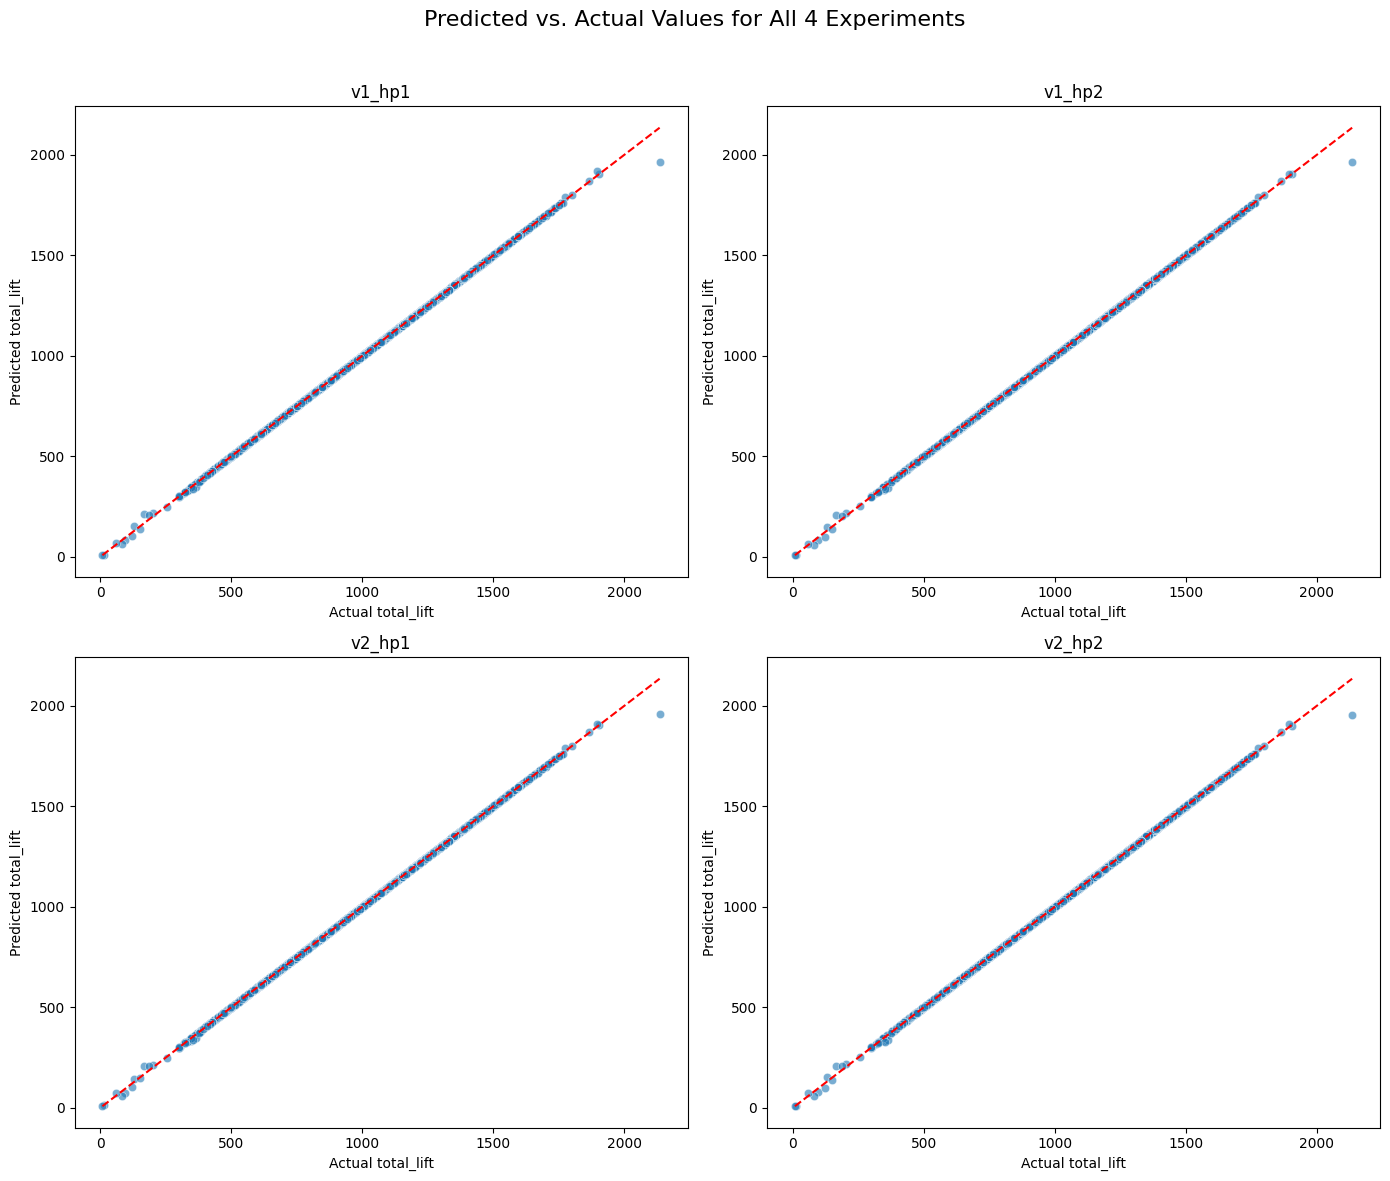

[codecarbon INFO @ 11:30:26] Energy consumed for RAM : 0.000550 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:30:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:26] Energy consumed for All CPU : 0.003896 kWh
[codecarbon INFO @ 11:30:26] 0.004446 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:41] Energy consumed for RAM : 0.000575 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:30:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:41] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 11:30:41] 0.004648 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:56] Energy consumed for RAM : 0.000600 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:30:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:30:56] Energy consumed for All CPU : 0.004251 kWh
[codecarbon INFO @ 11:30:56] 0.004851 kWh of 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Predicted vs. Actual Values for All 4 Experiments', fontsize=16)
axes = axes.flatten()

for i, run in results_df.iterrows():
    run_name = run['run_name']
    model = trained_models[run_name]
    features, target = experiment_datasets[run['feature_version']]
    _, X_test, _, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

    predictions = model.predict(X_test)

    sns.scatterplot(x=y_test, y=predictions, ax=axes[i], alpha=0.6)
    axes[i].set_title(run_name)
    axes[i].set_xlabel("Actual total_lift")
    axes[i].set_ylabel("Predicted total_lift")

    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('predicted_vs_actual_comparison.png')
plt.show()

/var/folders/wn/xn55n3vd25z62w3tbkvhcn780000gn/T/ipykernel_11423/739680827.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/wn/xn55n3vd25z62w3tbkvhcn780000gn/T/ipykernel_11423/739680827.py:20: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/wn/xn55n3vd25z62w3tbkvhcn780000gn/T/ipykernel_11423/739680827.py:21: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig('carbon_emission.png')
/opt/anaconda3/envs/mlops-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


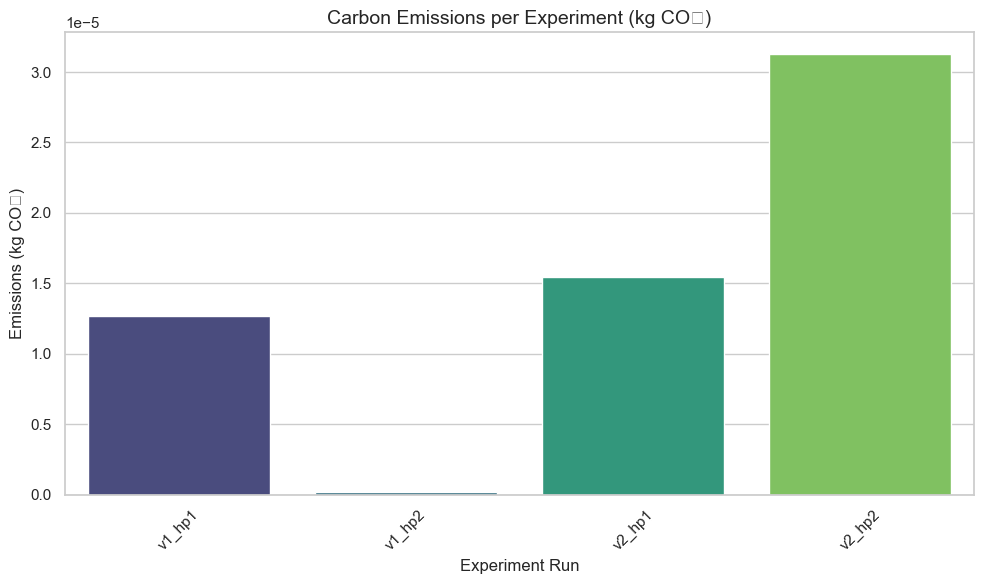

[codecarbon INFO @ 11:31:26] Energy consumed for RAM : 0.000650 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:31:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:26] Energy consumed for All CPU : 0.004605 kWh
[codecarbon INFO @ 11:31:26] 0.005255 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:31:41] Energy consumed for RAM : 0.000675 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:31:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:41] Energy consumed for All CPU : 0.004782 kWh
[codecarbon INFO @ 11:31:41] 0.005457 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:31:56] Energy consumed for RAM : 0.000700 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 11:31:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:31:56] Energy consumed for All CPU : 0.004959 kWh
[codecarbon INFO @ 11:31:56] 0.005659 kWh of 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    x="run_name",
    y="emissions_kg",
    data=results_df,
    palette="viridis"
)

plt.title("Carbon Emissions per Experiment (kg CO₂)", fontsize=14)
plt.ylabel("Emissions (kg CO₂)")
plt.xlabel("Experiment Run")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('carbon_emission.png')
plt.show()
